In [4]:
# !pip install HMMLearn

In [274]:
from hmmlearn.hmm import MultinomialHMM
from matplotlib import cm, pyplot as plt
import seaborn
from matplotlib.dates import YearLocator, MonthLocator, DayLocator
import pandas as pd
import numpy 
from datetime import datetime

In [16]:
def get_stock_data(file_name):
    """scrapes and cleans the data from the given file and creates a dataframe
    
    Args:
        file_name (string) : name of file
    
    Returns:
        df_stock (dataframe) : dataframe containing stock info scraped from file
    """
    df_stock = pd.DataFrame()
    file = open(file_name)
    txt = file.read()
    file.close()
    
    # split text into list, split by new line character
    txt = txt.split('\n')
    # get column titles
    columns = txt[0].split(',')

    for line in txt[1:]:
        temp_dict = dict()
        line = line.strip()
        line_list = line.split(',')

        # if row does not have sufficient column information, pass over
        if len(columns) != len(line_list):
            continue

        # add column's corresponding values to a temporary dictionary   
        for idx in range(len(columns)):
            column_name = columns[idx]
            
            # change all date column info to datetime object
            if column_name == 'Date':
                temp_dict[column_name] = datetime.strptime(line_list[idx], '%Y-%m-%d')
            else:
                temp_dict[column_name] = line_list[idx]

        # append dictionary to dataframe                                                  
        df_stock = df_stock.append(temp_dict, ignore_index=True)
    
    return df_stock

In [312]:
# Get the formatted data
file_name = 'a.us.txt'
df_a_stock = get_stock_data(file_name)
df_a_stock[:5]

,Close,Date,High,Low,Open,OpenInt,Volume
0,29.702,1999-11-18,33.754,27.002,30.713,0,66277506
1,27.257,1999-11-19,29.027,26.872,28.986,0,16142920
2,29.702,1999-11-22,29.702,27.044,27.886,0,6970266
3,27.002,1999-11-23,29.446,27.002,28.688,0,6332082
4,27.717,1999-11-24,28.309,27.002,27.083,0,5132147


In [141]:
def get_emission(stock_dataframe):
    """ Calculates the one day difference between stock closing value (today - yesterday)
        and determines emission symbol based on if stock price increased or decreased from previous day
    
    Args:
        stock_dataframe (dataframe) : dataframe containing stock info(close value, date, high, low, open, etc.)
    
    Returns:
        one_day_dif_df(dataframe) : dataframe containing the difference from the previous day's stock value
                                    as well as the related emission symbol (Increasing or Decreasing)
    """
    
    # Subset the initial DF to obtain only relevant columns
    one_day_dif_df = stock_dataframe.copy()
    one_day_dif_df = one_day_dif_df[['Date','Close']]
    
    # Convert CV to numeric for calculations
    one_day_dif_df['Close'] = pd.to_numeric(one_day_dif_df['Close'])
    one_day_dif_df['Yesterday Close'] = one_day_dif_df['Close'].shift()
    
    # Calculate the stock's closing price difference from the previous day
    one_day_dif_df['Close Value Difference'] = round((one_day_dif_df['Close'] - one_day_dif_df['Yesterday Close']),2)
    
    one_day_dif_df['Emission'] = 'NaN'
    row_indexes_inc = one_day_dif_df[one_day_dif_df['Close Value Difference']>=0].index
    row_indexes_dec = one_day_dif_df[one_day_dif_df['Close Value Difference']<0].index
    
    # Must use 1 and 0 to signify increasing & decreasing since MultinomialHMM .fit(X) can only take positive ints
    one_day_dif_df.loc[row_indexes_inc,'Emission']=int(1)
    one_day_dif_df.loc[row_indexes_dec,'Emission']=int(0)
    #one_day_dif_df['Emission'] = ['Increasing' if x > 0 else 'Decreasing' for x in one_day_dif_df['Close Value Difference']]
    
    return one_day_dif_df

In [354]:
# Set global constants
NUM_OBSERVATIONS = 250
NUM_COMPONENTS = 5

In [355]:
# Add emissions to the dataframe
df_with_emissions = get_emission(df_a_stock)[1:NUM_OBSERVATIONS+1] # Shift over by one since first emission is NaN

In [356]:
emissions = df_with_emissions['Emission']

# Reshape emissions for training
X = emissions.values.reshape(-1, 1)
X = X.tolist()

In [357]:
def get_random_distribution(size):
    rand_arr = numpy.random.rand(size, size)
    return rand_arr/rand_arr.sum(axis=1, keepdims=True)

In [373]:
# Create a single HMM

print("fitting to HMM and decoding ...", end="")

# Make an HMM instance and execute fit
model = MultinomialHMM(n_components=NUM_COMPONENTS, n_iter=100, init_params="e")

# randomize the initial state probabilities
# model.startprob_ = []

# randomize the initial transition probabilities
model.transmat_ = get_random_distribution(NUM_COMPONENTS)

# randomize the initial emission probabilities
# model.emissionprob_ = get_random_distribution(NUM_COMPONENTS)

# "train" the model
model.fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("done")

fitting to HMM and decoding ...done


In [348]:
# Print the score of the first model
#print(model.score(X))


# Create models with different initial transition probs to see which scores the highest
best_model = None
for i in range(10):
    model = MultinomialHMM(n_components=NUM_COMPONENTS, n_iter=100, init_params="emcs")
    
    rand_arr = numpy.random.rand(NUM_COMPONENTS, NUM_COMPONENTS)
    rand_dist = rand_arr/rand_arr.sum(axis=1, keepdims=True)

    model.transmat_ = rand_dist
    model.fit(X)
    
    print(model.predict(X))
    
    print(model.score(X))
    

-169.74381800800896
-167.15456862990413
-169.32861951642394
-169.7249479921678
-169.15569492757052
-168.88807911521863
-168.91830482089767
-168.81316905339705
-168.86092560681288
-168.65288250671807


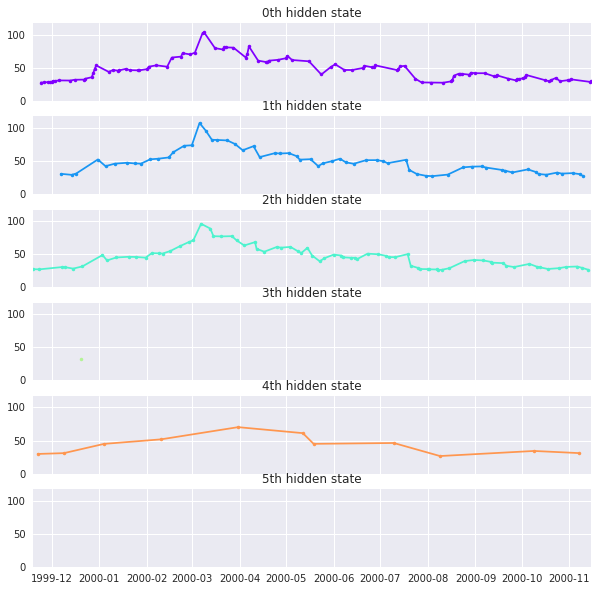

In [349]:
# print("Transition matrix")
# print(model.transmat_)
# print()

dates = df_with_emissions["Date"]
close_v = df_with_emissions["Close"]


fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
colours = cm.rainbow(numpy.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
#     ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

# set axis
plt.xlim(dates[1], dates[len(dates)])

# set y-axis
plt.ylim(0, numpy.amax(close_v) + 10)

# plt.xlim(1, 10)
fig.set_size_inches(10, 10)
seaborn.set()
plt.show()
